## 1. Introduction

Vehicle insurance fraud is a significant problem that involves false or exaggerated claims following an accident. Fraudsters may stage accidents, fabricate injuries, or engage in other deceptive practices to make claims. To address this issue, a kaggle dataset (*https://www.kaggle.com/datasets/shivamb/vehicle-claim-fraud-detection*) which includes information on vehicle attributes, accident details, and policy information has been used. The primary objective of this project is to develop a machine learning model that can assist insurance companies in identifying fraudulent claims.

## 2. Methodology

In this Jupyter notebook, I conducted an extensive analysis of the data, including exploring its characteristics, splitting it into training, validation, and testing sets using a stratified approach, and pre-processing it for machine learning. I employed various techniques such as encoding categorical features and scaling numerical features to ensure optimal performance of the models. Then, I trained and fine-tuned different algorithms, including logistic regression, support vector machine, and XGBoost, using random search CV with 5-fold cross-validation. After comparing their performance, the best ML model was selected based on precision, recall, and F1 score. Finally, after selecting the best model, a model interpretation analysis is conducted to gain valuable insights into the key predictors used in fraud detection.

## 3. Development of the Vehicle Insurance Fraud Detection ML Model

### 3.1 Import Libraries

In [1]:
# data manipulation
import pandas as pd

# mathematical functions
import numpy as np
from scipy.stats import randint, uniform
import random

# data visualization
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "notebook_connected"

# data splitting
from sklearn.model_selection import train_test_split

# data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
import category_encoders as ce
from category_encoders import BinaryEncoder
from sklearn.feature_selection import SelectKBest, f_classif

# algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# model training requirements
import warnings
from sklearn.model_selection import RandomizedSearchCV, KFold

# model evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

### 3.2 Data Collection

This dataset contains Time-related features, Policy and vehicle-related features, and Accident-related features to detect fraudulent claims.

In [2]:
# gathering dataset for building prediction model
df = pd.read_csv("C:/Users/aswinram/Aswin's Data Science Portfolio/Vehicle Insurance Fraud Detection/data/fraud_oracle.csv")

# remove spaces in columns name
df.columns = df.columns.str.replace(' ','_')

# print shape of df
print("The shape of df:", df.shape)

df.head()

The shape of df: (15420, 33)


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


##### Feature Recognition

This sub-section aims to improve the feature recognition process. It involves:

 1. Identifying the target feature - The feature that the model aims to predict.
 
 <br>
 
 2. Grouping input features - The input features are grouped into different categories based on their data type or characteristics, including:

   - All features: inlcludes all the input features
   
   - Numeric features: features that represent numerical values such as age, price, days, etc.

   - Categorical features: features that represent discrete values such as make, policy type, marital status, etc.
    
       - Binary features: features that represent only two possible values such as police report filed, witness present, etc.

       - Ordinal features: categorical features that have a natural order such as driver rating.

       - Nominal features: categorical features that have no natural order such as make, agent type, etc.

       - High cardinality features: categorical features that have a large number of unique values such as policy number.
    
By grouping the features into different categories, it can help to identify which features may require additional preprocessing or encoding to be used effectively in a model. It can also help to guide the feature engineering process and the feature selection process.


In [3]:
# -----TARGET SELECTION-----

# Output Feature
target_feature = 'FraudFound_P'
print("Target Feature: \n", target_feature)
print()



# -----INPUT FEATURE RECOGNITION-----


# -----all features-----
all_features = df.columns.to_list()
all_features.remove(target_feature)
print('All Features: \n', all_features)
print()


# -----numeric features-----
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'object' and df[feature].dtype !='datetime64[ns]']
numeric_features.remove(target_feature)
print('Numeric Features: \n', numeric_features)
print()


# -----categorical features-----
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'object']
print('Categorical Features: \n', categorical_features)
print()


# -----binary features-----
binary_features = ['AccidentArea', 'Sex', 'Fault', 'PoliceReportFiled', 'WitnessPresent', 'AgentType']
print('Binary Features: \n', binary_features)
print()


# -----ordinal features-----
ordinal_features = ['VehiclePrice', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 
                    'AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars']
print('Ordinal Features: \n', ordinal_features)
print()


# -----nominal features-----
nominal_features = ['Month', 'DayOfWeek', 'Make', 'DayOfWeekClaimed', 'MonthClaimed', 'MaritalStatus', 'PolicyType',
                   'VehicleCategory', 'BasePolicy']
print('Nominal Features: ', nominal_features)
print()


# -----high cardinality features-----

# Set the threshold for high cardinality
threshold = 7

# Calculate the number of unique values in each column
cardinality = df.nunique()

# Select the columns where the number of unique values is greater than the threshold
high_cardinality_features = cardinality[cardinality > threshold].index.tolist()

print('High cardinality features: ', high_cardinality_features)
print()

Target Feature: 
 FraudFound_P

All Features: 
 ['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex', 'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePrice', 'PolicyNumber', 'RepNumber', 'Deductible', 'DriverRating', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year', 'BasePolicy']

Numeric Features: 
 ['WeekOfMonth', 'WeekOfMonthClaimed', 'Age', 'PolicyNumber', 'RepNumber', 'Deductible', 'DriverRating', 'Year']

Categorical Features: 
 ['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePrice', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFile

### 3.3 Exploratory Data Anlysis

Exploratory Data Analysis (EDA) plays a crucial role in enhancing the performance of machine learning models. It helps in identifying errors, detecting patterns, selecting relevant features, improving model accuracy, and effectively communicating insights. In this section, histograms are created for both numerical and categorical features along with the colored target feature to determine the presence of fraudulent activities across different input features. This step provides essential insights into the data and assists in making informed decisions for the subsequent stages of the model development process.

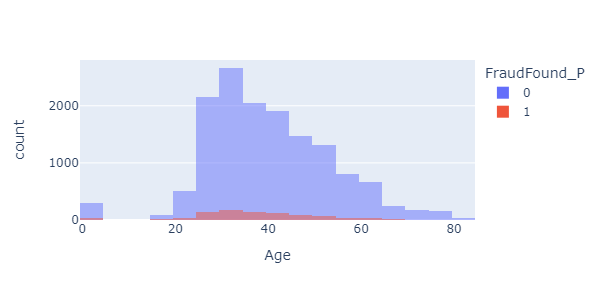

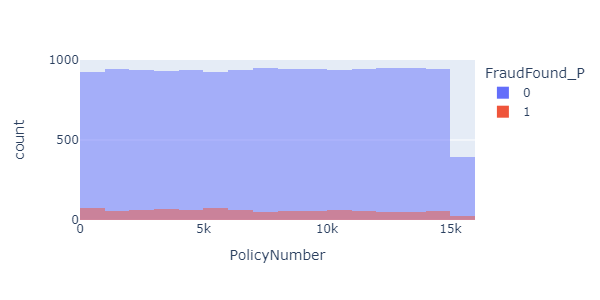

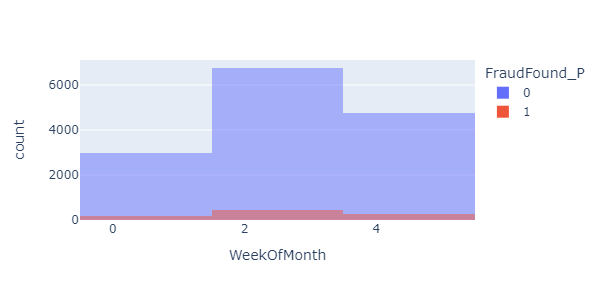

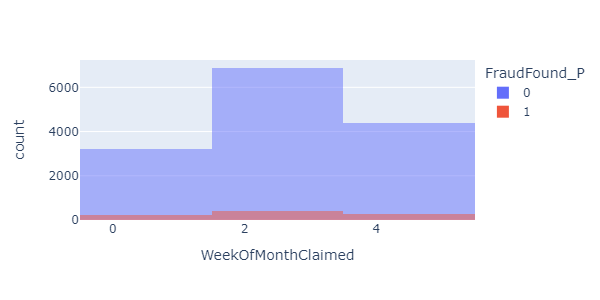

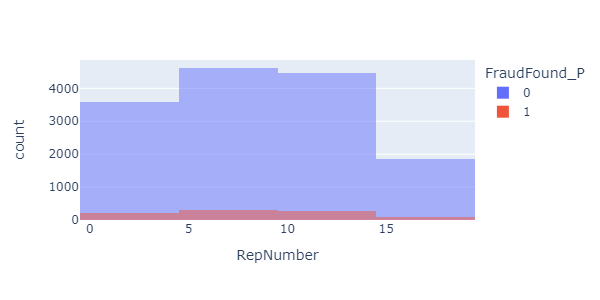

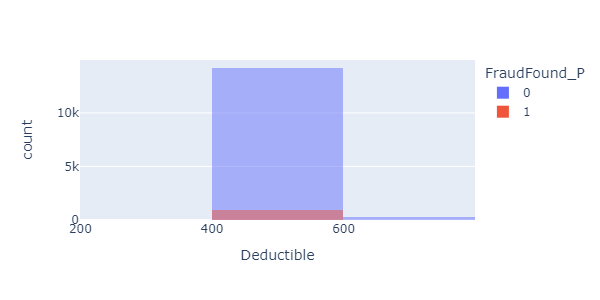

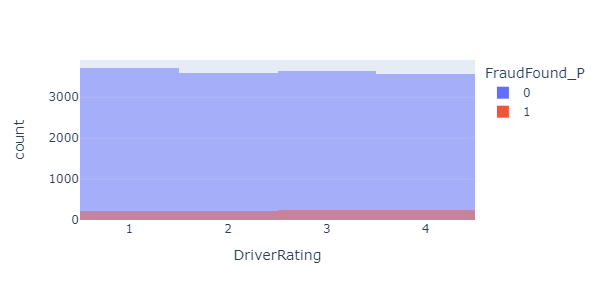

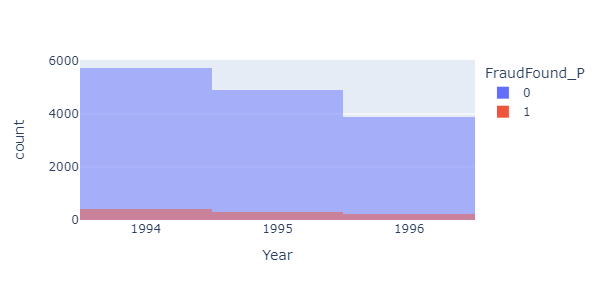

In [4]:
# determine if numeric feature is discrete or continuous 
continuous_numeric_features = []
discrete_numeric_features = []
for col in numeric_features:
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        if len(df[col].unique()) > 20:
            continuous_numeric_features.append(col)
        else:
            discrete_numeric_features.append(col)

# Create histograms for continuous numeric features
for col in continuous_numeric_features:
    fig = px.histogram(df, x=col, nbins=20, color=target_feature, barmode="overlay", width = 600, height = 300)
    fig.show(renderer="png", scale = 1)
    
# Create histograms for discrete numeric features
for col in discrete_numeric_features:
    fig = px.histogram(df, x=col, nbins=4, color=target_feature, barmode="overlay", width = 600, height = 300)
    fig.show(renderer="png", scale = 1)

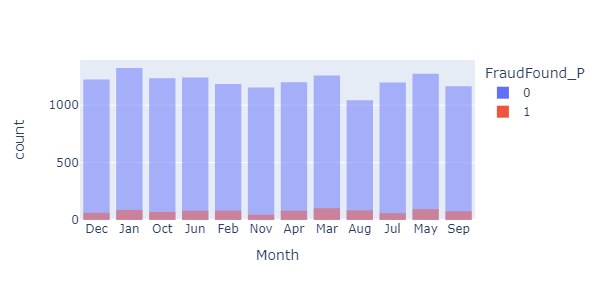

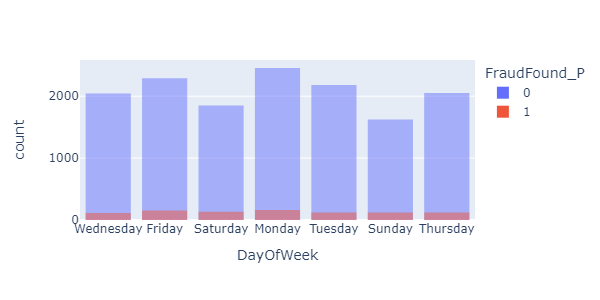

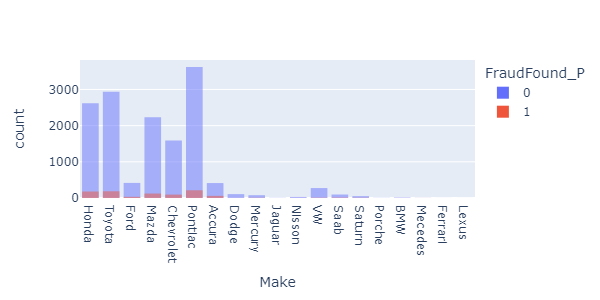

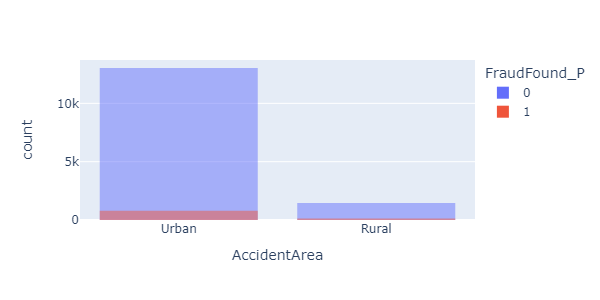

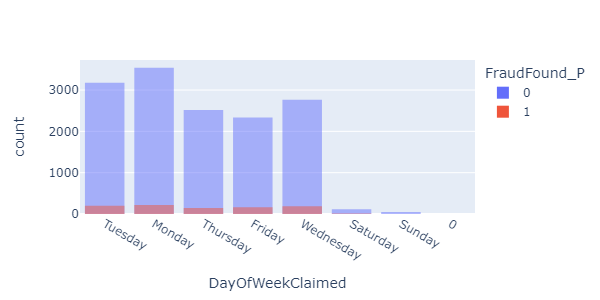

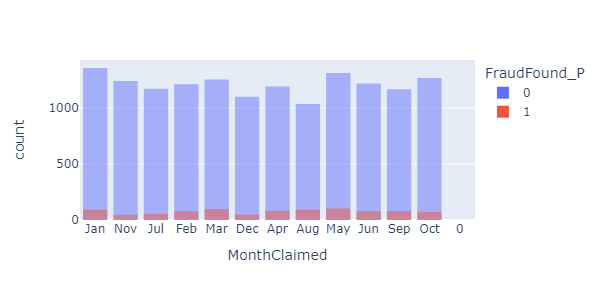

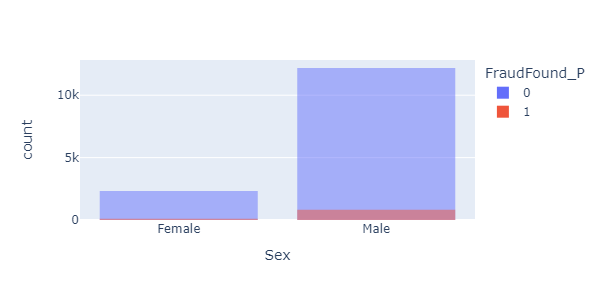

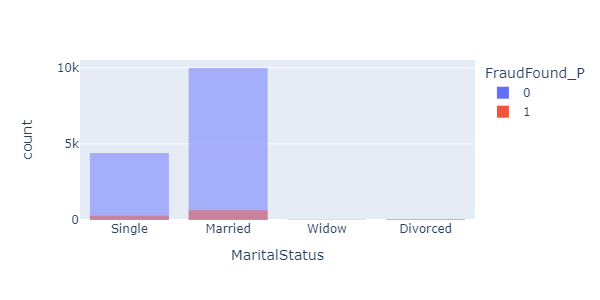

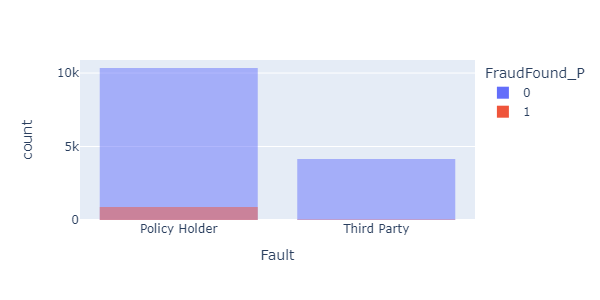

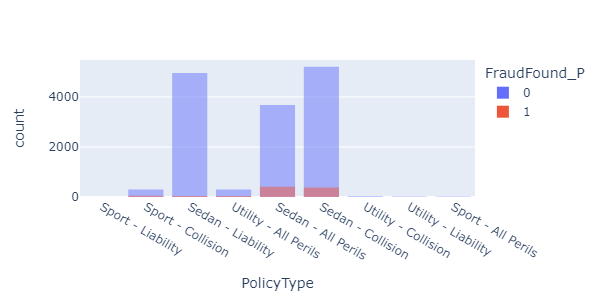

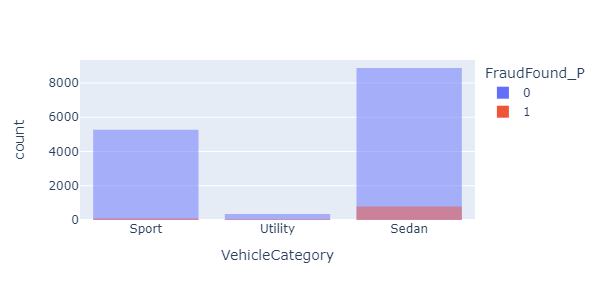

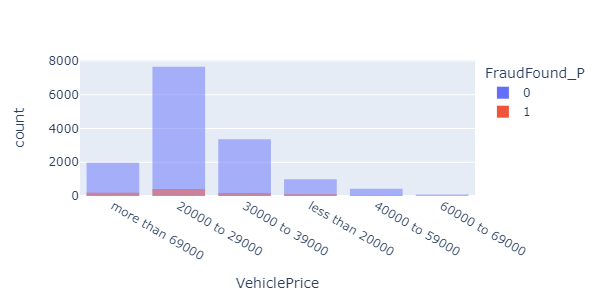

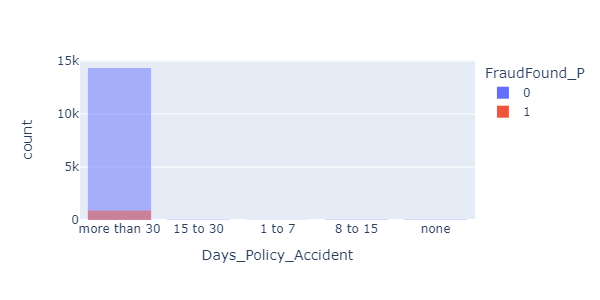

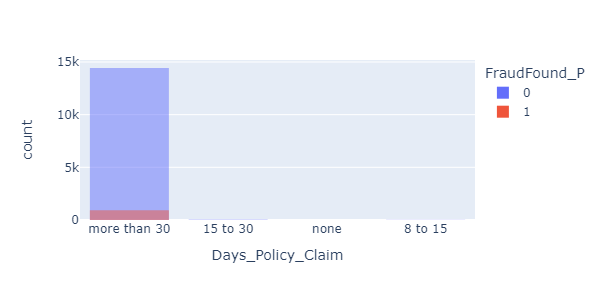

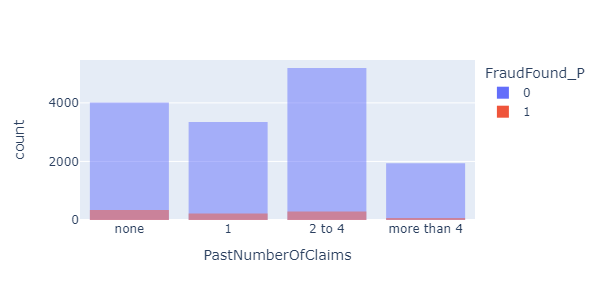

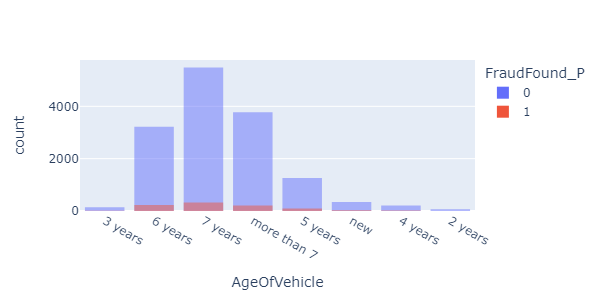

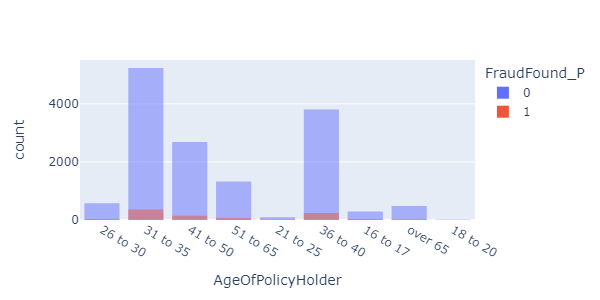

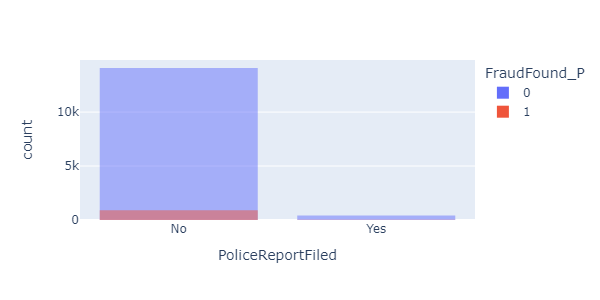

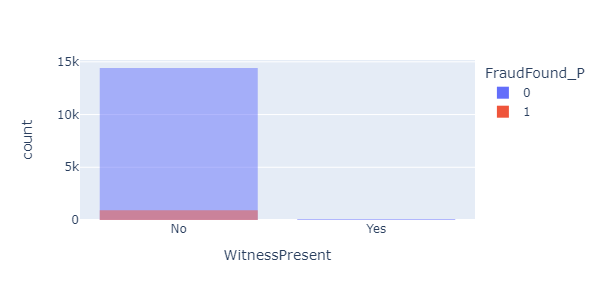

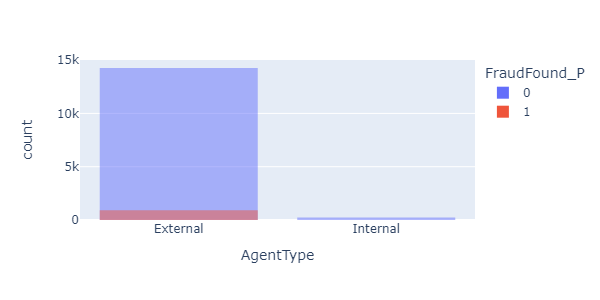

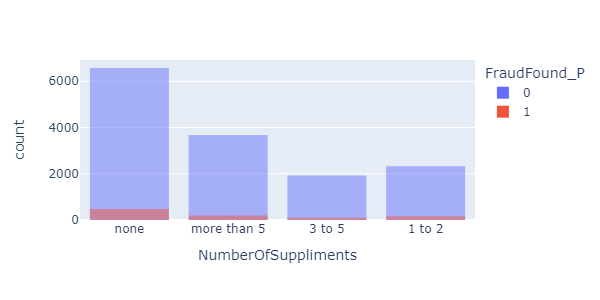

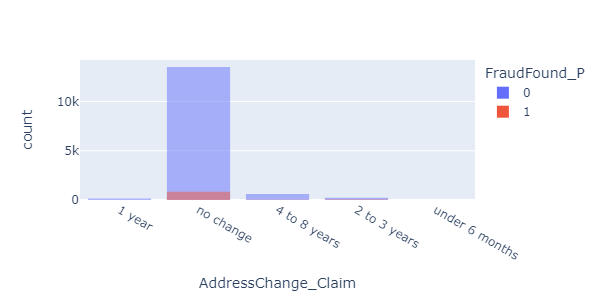

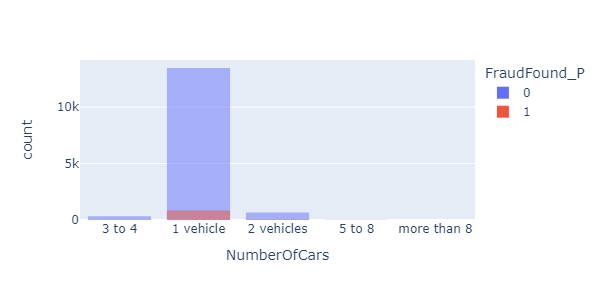

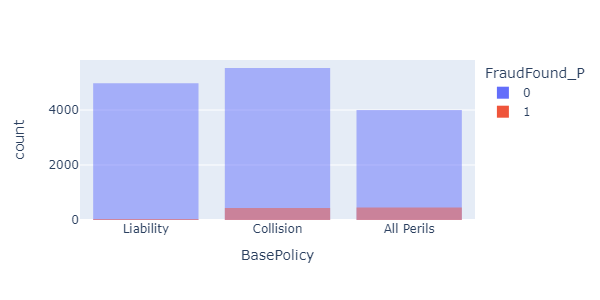

In [5]:
# Create bar plots for categorical features
for col in categorical_features:
    fig = px.histogram(df, x=col, color=target_feature, barmode="overlay", width = 600, height = 300)
    fig.show(renderer="png", scale = 1)

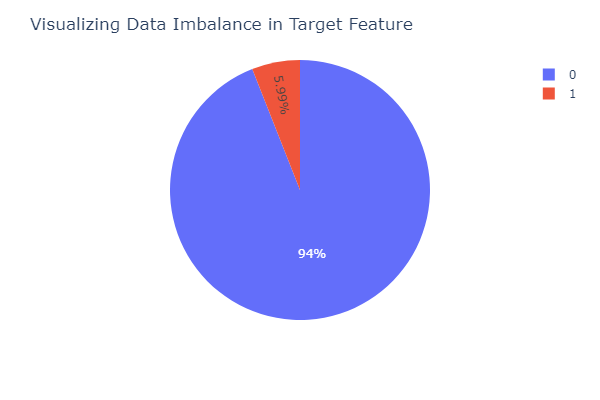

In [6]:
# chart for target_feature
fig = px.pie(df, values=df.groupby('FraudFound_P').size().values, names=df.groupby('FraudFound_P').size().index)
fig.update_layout( title="Visualizing Data Imbalance in Target Feature", width=600, height=400)
fig.show(renderer="png", scale = 1)

In [7]:
# Check if there are any missing values in the DataFrame
if df.isnull().any().any():
    print('There are missing values in the DataFrame')
else:
    print('There are no missing values in the DataFrame')

There are no missing values in the DataFrame


### 3.4 Data Splitting

Data splitting into train, validation, and test sets is important for machine learning to ensure the model's performance is evaluated on unseen data and to avoid overfitting. Stratifying the y variable is important to preserve the distribution of the target variable in each set, especially for imbalanced datasets. For the size of the dataset used in this project, stratification ensures representative data is used for training, validation, and testing, leading to accurate model performance evaluation. In addition, Feature selection an important step in Data Preprocessing is intertwined with data splitting for efficiency and unnecessary computation avoidance.

*Note: While all features in the dataset were included in this section as they provided the best ML performance, it's important to note that in the real world, it's necessary to conduct rigorous experimentation to identify the best subset of features from all the available features in the input dataset.*

In [8]:
# Assign input features (also for feature selection)
X = df[['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy']]

# Assign Target Feature
y = df[target_feature]


# Perform stratified train_val-test split for input features
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, stratify= y_train_val, random_state=0)


# Print shapes of the datasets
print('Shape of X_train: ', X_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of X_val: ', X_val.shape)
print('Shape of y_val: ', y_val.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)
print()

# Dataset Splitting Summary
total_samples = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

train_percent =  X_train.shape[0] / total_samples * 100
val_percent = X_val.shape[0] / total_samples * 100
test_percent = X_test.shape[0] / total_samples * 100

print(f"Training set percentage: {train_percent:.2f}%")
print(f"Validation set percentage: {val_percent:.2f}%")
print(f"Test set percentage: {test_percent:.2f}%")

Shape of X_train:  (9252, 32)
Shape of y_train:  (9252,)
Shape of X_val:  (2313, 32)
Shape of y_val:  (2313,)
Shape of X_test:  (3855, 32)
Shape of y_test:  (3855,)

Training set percentage: 60.00%
Validation set percentage: 15.00%
Test set percentage: 25.00%


### 3.5 Data Preprocessing

Data preprocessing is an essential step in machine learning that involves transforming raw data into a format suitable for modeling. The process includes data cleaning, feature engineering, and feature scaling, among others. In this case, data cleaning was not performed since the dataset has no missing values. Also, outlier detection was not carried out since this is a classification problem. However, other preprocessing techniques such as feature engineering and scaling techniques are used to improve model performance.

##### Feature Engineering

Feature engineering is crucial for machine learning modeling. In my approach, I utilized different encoding techniques such as count encoder for high cardinality features, binary encoder for binary features, ordinal encoding for ordinal features, and one hot encoder for nominal features to preprocess the features for improved model performance.

In [9]:
# Create an instance of CountEncoder 
c_encoder = ce.CountEncoder()

# get updated high cardinality feature names
high_cardinality_features = np.intersect1d(high_cardinality_features, X.columns)

# fit_transform object on train set and transform on test set
X_train_c_encoded, X_val_c_encoded, X_test_c_encoded = c_encoder.fit_transform(X_train[high_cardinality_features]), c_encoder.transform(X_val[high_cardinality_features]), c_encoder.transform(X_test[high_cardinality_features])

In [10]:
# Create an instance of BinaryEncoder
b_encoder = BinaryEncoder()

# get updated binary feature names
binary_features = np.intersect1d(binary_features, X.columns)

# fit_transform object on train set and transform on test set
X_train_b_encoded, X_val_b_encoded, X_test_b_encoded = b_encoder.fit_transform(X_train[binary_features]), b_encoder.transform(X_val[binary_features]), b_encoder.transform(X_test[binary_features])

In [11]:
# specify the order of categories for each feature
categories = [
    ['less than 20000', '20000 to 29000', '30000 to 39000', '40000 to 59000', '60000 to 69000', 'more than 69000' ], # VehiclePrice
    ['none', '1 to 7', '8 to 15', '15 to 30', 'more than 30'], # Days_Policy_Accident
    ['none', '8 to 15' , '15 to 30', 'more than 30' ], # Days_Policy_Claim
    ['none', '1' , '2 to 4', 'more than 4'], # PastNumberOfClaims
    ['new', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', 'more than 7'], # AgeOfVehicle
    ['16 to 17',  '18 to 20', '21 to 25', '26 to 30', '31 to 35', '36 to 40', '41 to 50', '51 to 65', 'over 65'], # AgeOfPolicyHolder
    ['none', '1 to 2', '3 to 5', 'more than 5'], # NumberOfSuppliments
    ['no change', 'under 6 months', '1 year', '2 to 3 years', '4 to 8 years'], #AddressChange_Claim
    ['1 vehicle', '2 vehicles', '3 to 4', '5 to 8', 'more than 8'], # NumberOfCars    
]

# Create an instance of Ordinal Encoder
ord_encoder = OrdinalEncoder(categories=categories)

# fit_transform object on train set and transform on test set
X_train_ord_encoded, X_val_ord_encoded, X_test_ord_encoded = ord_encoder.fit_transform(X_train[ordinal_features]), ord_encoder.transform(X_val[ordinal_features]), ord_encoder.transform(X_test[ordinal_features])

# Get the names of the ordinal columns
column_names = ordinal_features

# convert X_train_encoded, X_val_encoded, X_test_encoded numpy array to DataFrame
X_train_ord_encoded, X_val_ord_encoded, X_test_ord_encoded = pd.DataFrame(X_train_ord_encoded, columns=column_names), pd.DataFrame(X_val_ord_encoded, columns=column_names), pd.DataFrame(X_test_ord_encoded, columns=column_names)

In [12]:
# Create an instance of OneHotEncoder
encoder = OneHotEncoder(handle_unknown = 'ignore')

# get updated nominal feature names
nominal_features = np.intersect1d(nominal_features, X.columns)

# fit_transform object on train set and transform on test set
X_train_o_encoded, X_val_o_encoded, X_test_o_encoded = encoder.fit_transform(X_train[nominal_features]), encoder.transform(X_val[nominal_features]), encoder.transform(X_test[nominal_features])

# Get the names of the nominal columns
column_names = encoder.get_feature_names_out(nominal_features)

# convert X_train_encoded, X_val_encoded, X_test_encoded to dense numpy array
X_train_o_encoded, X_val_o_encoded, X_test_o_encoded = X_train_o_encoded.toarray(), X_val_o_encoded.toarray(), X_test_o_encoded.toarray()

# convert X_train_encoded, X_val_encoded, X_test_encoded dense numpy array to DataFrame
X_train_o_encoded, X_val_o_encoded, X_test_o_encoded = pd.DataFrame(X_train_o_encoded, columns=column_names), pd.DataFrame(X_val_o_encoded, columns=column_names), pd.DataFrame(X_test_o_encoded, columns=column_names)

In [13]:
# Combine the encoded DataFrames

# Reset the index of each DataFrame
X_train_c_encoded, X_train_b_encoded, X_train_ord_encoded, X_train_o_encoded = X_train_c_encoded.reset_index(drop=True), X_train_b_encoded.reset_index(drop=True), X_train_ord_encoded.reset_index(drop=True), X_train_o_encoded.reset_index(drop=True)
X_val_c_encoded, X_val_b_encoded, X_val_ord_encoded, X_val_o_encoded = X_val_c_encoded.reset_index(drop=True), X_val_b_encoded.reset_index(drop=True), X_val_ord_encoded.reset_index(drop=True), X_val_o_encoded.reset_index(drop=True)
X_test_c_encoded, X_test_b_encoded, X_test_ord_encoded, X_test_o_encoded = X_test_c_encoded.reset_index(drop=True), X_test_b_encoded.reset_index(drop=True), X_test_ord_encoded.reset_index(drop=True), X_test_o_encoded.reset_index(drop=True)

# Combine the encoded DataFrames using pd.concat
X_train_encoded = pd.concat([X_train_c_encoded, X_train_b_encoded, X_train_ord_encoded, X_train_o_encoded], axis=1)
X_val_encoded = pd.concat([X_val_c_encoded, X_val_b_encoded, X_val_ord_encoded, X_val_o_encoded], axis=1)
X_test_encoded = pd.concat([X_test_c_encoded, X_test_b_encoded,X_test_ord_encoded, X_test_o_encoded], axis=1)

##### Feature Scaling

Feature scaling is important for machine learning modeling as it transforms the features to a common scale, ensuring that no single feature dominates the others during model training. Scaling can help improve model performance by reducing the impact of the differences in feature scales, which can otherwise lead to biased results. In this jupyter notebook, I have used sklearn's StandardScaler to perform the feature scaling on the X_train_encoded, X_val_encoded, X_test_encoded datasets.

In [14]:
# Create an instance of StandardScaler
scaler = StandardScaler(with_mean=False)

# fit_transform object on train set and transform on test set
X_train_scaled, X_val_scaled, X_test_scaled = scaler.fit_transform(X_train_encoded), scaler.transform(X_val_encoded), scaler.transform(X_test_encoded)

### 3.6 Model Training & Evaluation

Model training involves selecting an appropriate algorithm and fine-tuning its parameters to obtain the best possible model for a given dataset. In this case, logistic regression, support vector, and XGBoost classifiers were trained and fine-tuned using random search CV with 5-fold cross-validation. The best model selected based on cross-validation performance was then trained on the entire train set and evaluated on the validation set. Once the model was optimized, it was evaluated on the test set to ensure that it generalizes well to unseen data.

During model training, it is essential to monitor for underfitting and overfitting. Underfitting occurs when a model is too simple to capture the underlying patterns in the data, resulting in poor performance on both the training and validation sets. Overfitting, on the other hand, occurs when a model is too complex and captures noise in the training data, leading to excellent performance on the training set but poor performance on the validation set.

To ensure good performance on the test set, it is crucial to select a model that achieves a balance between underfitting and overfitting. The selected model should have good performance on both the training and validation sets while also generalizing well to the test set. A model that achieves good performance on the test set is likely to perform well on new, unseen data, and is considered to be a good model.

##### Model definition & Hyperparameter tuning with Random Search CV

In [15]:
# define the models and hyperparameter search spaces
models = {
    'lr': {
        'model': LogisticRegression(random_state=0),
        'param_distributions': {
            # Regularization strength
            'C': np.logspace(-10, 10, 21),
            # Solver for optimization
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
            # Maximum number of iterations
            'max_iter': randint(100, 1000),
        }
    },
    
    'svc': {
        'model': SVC(random_state=0),
            'param_distributions': {
            # the type of kernel to use
            'kernel': ['linear', 'poly', 'rbf'],
            # regularization parameter
            'C': [0.1, 1, 10, 100],
            # kernel coefficient (for poly, and rbf)
            'gamma': ['scale', 'auto'],
            # degree of the polynomial kernel function (for poly)
            'degree': [2, 3, 4],
            # penalty parameter of the error term
            'coef0': [-1, 0, 1],
        }
    },

   'xgb': {
    'model': XGBClassifier(random_state=0),
    'param_distributions': {
               # number of estimators
               'n_estimators': [50, 300],
               # learning rate
               'learning_rate': [0.01, 0.1],
               # Regularization parameter
               'max_depth': [3, 7],
               # Regularization parameter
               'min_child_weight': [1, 5],
               # Regularization parameter
               'gamma': [0.5, 1],
               # subsample ratio of columns when constructing each tree
              'colsample_bytree': [0.3, 0.7]

        }
    }

}


# Define cross-validation method
cv = KFold(n_splits=5)

# Perform hyperparameter tuning on all models
best_models = {}
for name in models:
    print(f'{name}:')
    
    # ignore all warnings
    warnings.filterwarnings('ignore')
    
    # define the random search object
    random_search = RandomizedSearchCV(
        models[name]['model'],
        param_distributions=models[name]['param_distributions'],
        n_iter=5, 
        cv=cv,
        scoring='f1_macro',
        random_state=0)
    
    # perform hyperparameter tuning with random search
    random_search.fit(X_train_scaled, y_train)
    
    # get the best model and its hyperparameters
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    
    # store the best model in the dictionary
    best_models[name] = {'model': best_model, 'params': best_params}

    # print best hyperparameters and best score
    print(f'Best hyperparameters: {random_search.best_params_}')
    print(f'Best f1 score: {random_search.best_score_:.3f}')
    print()

lr:
Best hyperparameters: {'C': 100.0, 'max_iter': 659, 'solver': 'lbfgs'}
Best f1 score: 0.488

svc:
Best hyperparameters: {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'coef0': -1, 'C': 100}
Best f1 score: 0.489

xgb:
Best hyperparameters: {'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.7}
Best f1 score: 0.702



##### Identify the best model using random search results

In [16]:
# get best model name and score
best_model = best_models['xgb']['model']

print('Best Model:', best_model)

Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)


##### Model performance on Entire Train Set

In [17]:
# fit model on entire train set
best_model.fit(X_train_scaled, y_train)

# predict model on train set
y_pred_train = best_model.predict(X_train_scaled)

# Generate the classification report
report = classification_report(y_train, y_pred_train)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8698
           1       1.00      0.99      1.00       554

    accuracy                           1.00      9252
   macro avg       1.00      1.00      1.00      9252
weighted avg       1.00      1.00      1.00      9252



##### Model performance on Validation Set

In [18]:
# predict model on val set
y_pred_val = best_model.predict(X_val_scaled)

# Generate the classification report
report = classification_report(y_val, y_pred_val)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2175
           1       0.81      0.37      0.51       138

    accuracy                           0.96      2313
   macro avg       0.89      0.68      0.74      2313
weighted avg       0.95      0.96      0.95      2313



##### Model performance on Test Set

In [19]:
# predict model on test set
y_pred_test = best_model.predict(X_test_scaled)

# Generate the classification report
report = classification_report(y_test, y_pred_test)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      3624
           1       0.81      0.35      0.49       231

    accuracy                           0.96      3855
   macro avg       0.89      0.67      0.73      3855
weighted avg       0.95      0.96      0.95      3855



### 3.7 Model Interpretation

Model interpretation is the process of understanding how a machine learning model works and why it makes certain predictions. It helps to gain insights into the underlying relationships between the input features and the target variable. One way to interpret a model is to analyze the importance of the input features on the model's predictions.

In [ ]:
# store xgboost as model
model = best_model

# Get feature importances using the "gain" metric
importances = model.feature_importances_

# Create a dictionary with the feature names and their respective importances
feature_scores = dict(zip(X_test.columns, importances))

# Sort the features based on their importances in descending order
sorted_features = {k: v for k, v in sorted(feature_scores.items(), key=lambda item: item[1], reverse=True)}

# Select the top 25 features based on their importances
top_features = list(sorted_features.keys())[:20]

# Generate random colors for each feature
colors = px.colors.qualitative.Light24_r

# Plot the top 25 features based on their importances
fig = go.Figure()
fig.add_trace(go.Bar(x=top_features, y=[sorted_features[f] for f in top_features], marker_color=colors))
fig.update_layout(title='Top 20 Features based on XGBoost Feature Importance', xaxis_title='Features', yaxis_title='Importance')
fig.show(renderer="png", scale=10)

## 4. Conclusion

In conclusion, this Jupyter notebook presented various stages of the ML model development process for the vehicle insurance fraud detection dataset, including data preprocessing, machine learning model training and evaluation, and model interpretation. Amongst the logistic regression, support vector, and XGBoost classifiers, the XGBoost classifier yielded the best performance and therefore, it is selected as the best model owing to its performance on precision, recall, and F1 score. Overall, having an F1 score of 1 on the training set and 0.95 on the validation and test sets is a good indication that the XGBoost model has learned to generalize well and is performing well. Lastly, after model selection, the model interpretation analysis using XGBoost model's feature importances reveal that Vehicle Price, Policy Number, and Age of Policy holder are some of the most important predictors of fraud. In summary, the results demonstrate the effectiveness of the developed XGBoost model in detecting fraudulent claims, making it a valuable resource for insurance companies looking to improve their vehicle insurance fraud detection capabilities. 